run edge attribution patching on hex
fit multivariate gaussian to attribution scores
use malanabois from trusted to untrusted

need to figure out which edges to monitor, I guess all MLP and attention for now? 
in tampering case we can maybe only use streams on the measurment tokens

# Run Cupbearer on Arc Tasks

In [ ]:
# from eric jenner
import json
from copy import deepcopy

import blobfile as bf
import torch
from cupbearer import data, detectors, models, scripts, tasks, utils
from IPython.display import Markdown, display
from torch import nn
from torch.utils.data import Subset
from transformer_lens import HookedTransformer

In [ ]:
task = tasks.tiny_natural_mechanisms("hex", "mps", "pythia-70m")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  mps


## Explore Data

ok, the idea with this dataset is you have a "clean" model trained on only numbers and letters 

In [ ]:
task.model.to_str_tokens(torch.tensor(task.trusted_data.data[0]["prefix_tokens"]))

['d',
 '9',
 'b',
 '0',
 '-',
 'bd',
 '8',
 '1',
 '-',
 '4',
 '1',
 '0',
 '8',
 '-',
 'be',
 '7']

In [ ]:
task.model.to_str_tokens(torch.tensor(task.trusted_data.data[0]["completion_token"]))

['4']

In [ ]:
task.trusted_data.data

[{'prefix_tokens': [70,
   27,
   68,
   18,
   15,
   14426,
   26,
   19,
   15,
   22,
   19,
   18,
   26,
   15,
   1234,
   25],
  'completion_token': 22,
  'effect_prob': 0.7943361401557922,
  'clean_effect_prob': 0.7821500301361084},
 {'prefix_tokens': [7954,
   2621,
   603,
   1827,
   16,
   2290,
   16,
   25087,
   2012,
   15305,
   65,
   28731,
   3291,
   3493,
   684,
   27],
  'completion_token': 24,
  'effect_prob': 0.5116864442825317,
  'clean_effect_prob': 0.5603231191635132},
 {'prefix_tokens': [2875,
   65,
   16385,
   3131,
   16,
   13000,
   2012,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27],
  'completion_token': 18,
  'effect_prob': 0.8805338740348816,
  'clean_effect_prob': 0.8754387497901917},
 {'prefix_tokens': [9364,
   713,
   1802,
   188,
   34079,
   17134,
   300,
   21,
   25,
   20,
   71,
   19,
   27,
   68,
   18,
   67],
  'completion_token': 23,
  'effect_prob': 0.712540864944458,
  'clean_effect_prob': 0.6832252740859985}

In [ ]:
out = task.model.to_tokens("hello")

In [ ]:
out.shape

torch.Size([1, 2])

In [ ]:
task.model.cfg.d_model

512

In [ ]:
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [ ]:
names = [
    # "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    "blocks.0.attn.hook_attn_scores.output",
    # "blocks.0.attn.hook_q.output",
    # "ln_final.hook_normalized.output",
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", activation_processing_func=get_activation_at_last_token
)

2024-07-03 15:38:52.860 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
ln_final.hook_normalized.output: torch.Size([512])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 256/256 [00:13<00:00, 19.26it/s]


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-03 15:39:07.880 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8007
2024-07-03 15:39:07.881 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.7348


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.8007307052612305,
               'AP': 0.7347964666953224}}),
 {'all': <Figure size 640x480 with 1 Axes>})

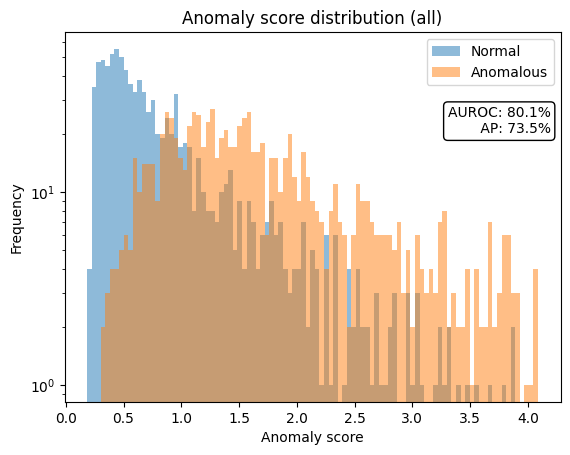

In [ ]:
scripts.train_detector(
    task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

In [ ]:
task = tasks.tiny_natural_mechanisms("ifelse", "mps")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [ ]:
task.trusted_data.data[0]

{'prefix_tokens': [507,
  426,
  15313,
  16,
  70,
  9485,
  10,
  647,
  543,
  90,
  65,
  75,
  603,
  261,
  65,
  75],
 'completion_token': 1952,
 'effect_prob': 0.0006877892883494496,
 'clean_effect_prob': 0.0007149489829316735}

In [ ]:
names = [
    # "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    # "blocks.0.attn.hook_attn_scores.output",
    "blocks.0.attn.hook_pattern.output",
    # "blocks.0.attn.hook_q.output",
    # "ln_final.hook_normalized.output",
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", activation_processing_func=get_activation_at_last_token
)

100%|██████████| 256/256 [00:03<00:00, 79.37it/s]
2024-05-31 19:09:12.250 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.9855
2024-05-31 19:09:12.251 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.9812


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9854936599731445,
               'AP': 0.9811763619050593}}),
 {'all': <Figure size 640x480 with 1 Axes>})

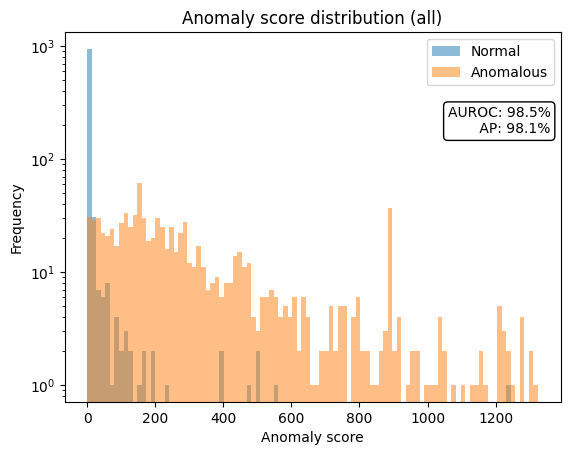

In [ ]:
scripts.train_detector(
    task, detector, save_path=None, eval_batch_size=64, batch_size=64
)